# Preliminary analysis of the dataset

In [42]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

import utils
import os

import glob
import random

%matplotlib inline

## Visualization of the images

<sunpy.map.mapbase.GenericMap object at 0x7f93cb0f2d70>
SunPy Map
---------
Observatory:		 
Instrument:		 
Detector:		 
Measurement:		 Unknown
Wavelength:		 Unknown
Observation Date:	 2016-09-30 00:00:05
Exposure Time:		 Unknown
Dimension:		 [256. 256.] pix
Coordinate System:	 helioprojective
Scale:			 [0.00266984 0.00266984] deg / pix
Reference Pixel:	 [127.15937806 127.265625  ] pix
Reference Coord:	 [0. 0.] deg                   
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
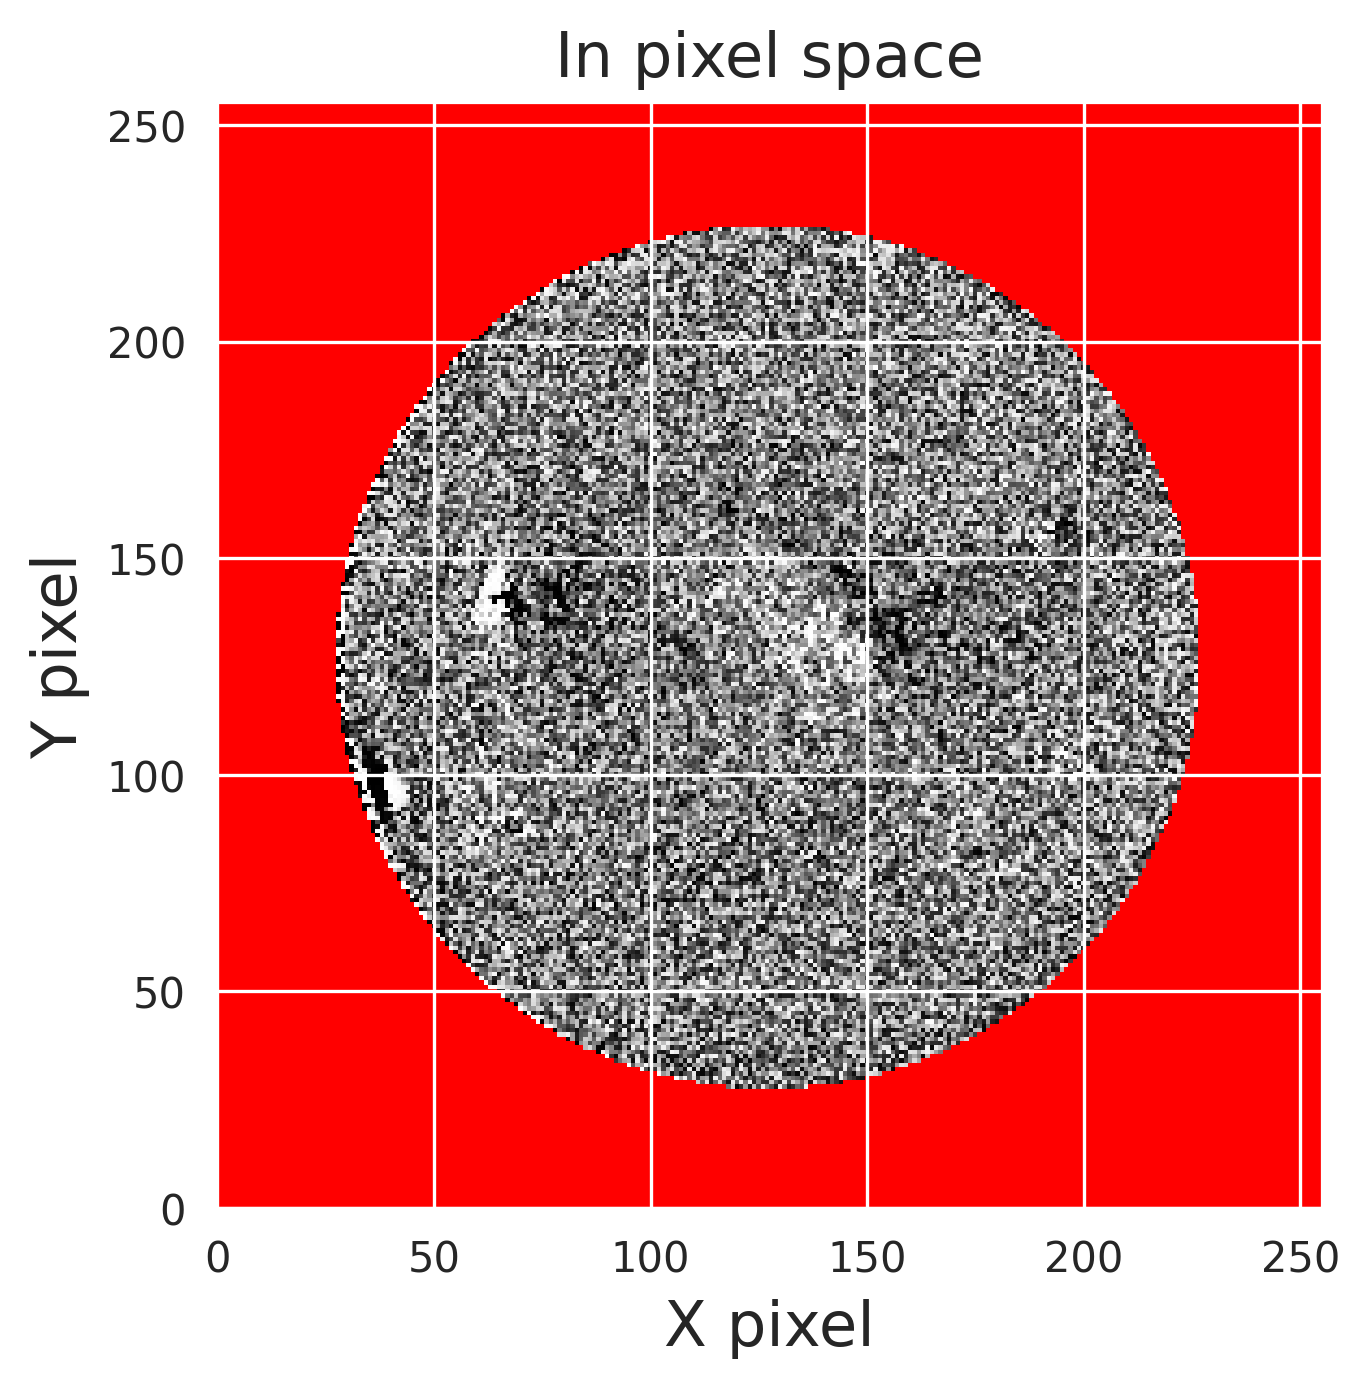
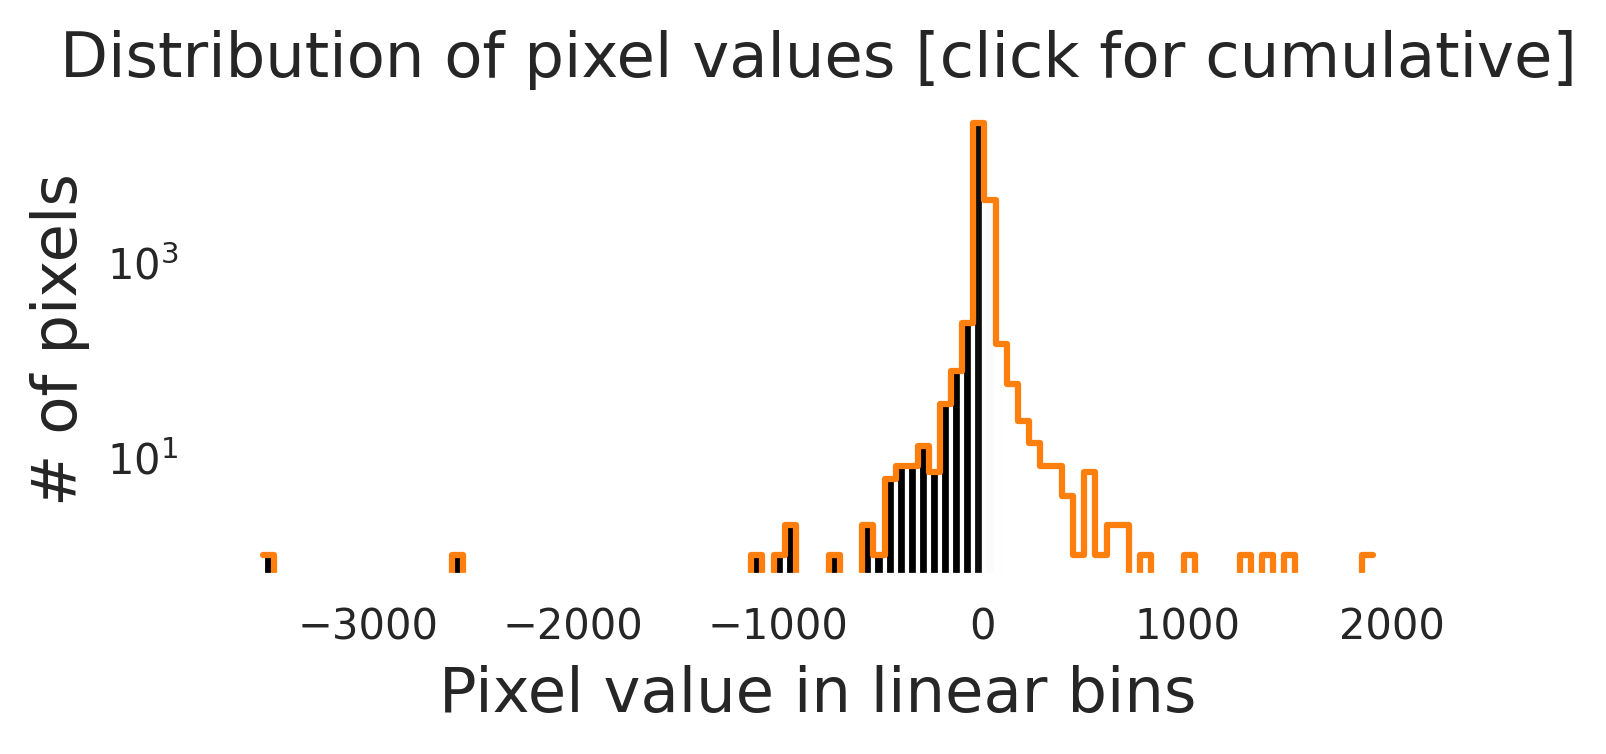

In [43]:
HMIm_example = sunpy.map.Map("data/hmi_magnetogram/2016-10-04T00-01-30.fits")
HMIm_example

In [44]:
HMIm_2016 = sunpy.map.Map("data/hmi_magnetogram/2016*.fits")

<sunpy.map.mapbase.GenericMap object at 0x7f92758298d0>
SunPy Map
---------
Observatory:		 
Instrument:		 
Detector:		 
Measurement:		 Unknown
Wavelength:		 Unknown
Observation Date:	 2015-12-31 21:00:03
Exposure Time:		 Unknown
Dimension:		 [256. 256.] pix
Coordinate System:	 helioprojective
Scale:			 [0.00266984 0.00266984] deg / pix
Reference Pixel:	 [127.08625031 127.05374906] pix
Reference Coord:	 [0. 0.] deg                   
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
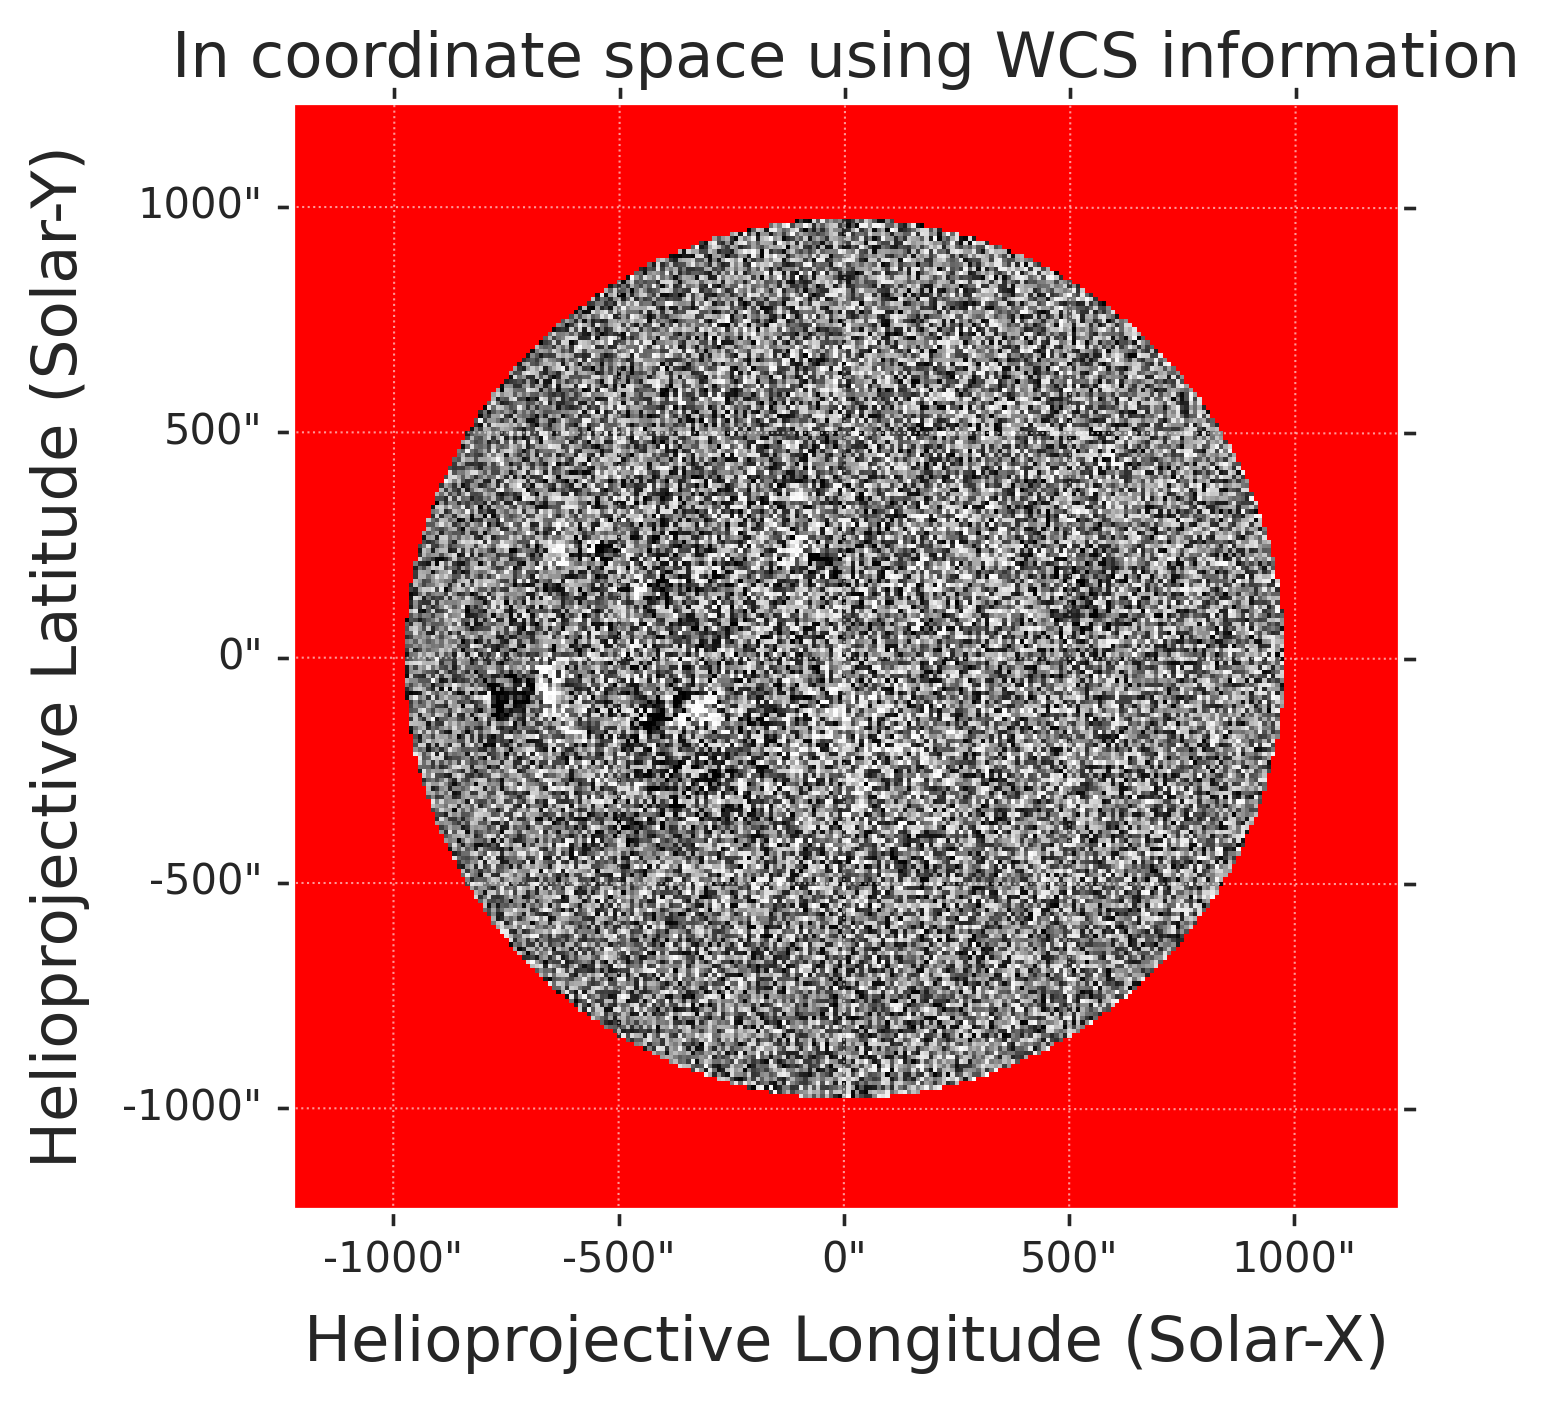
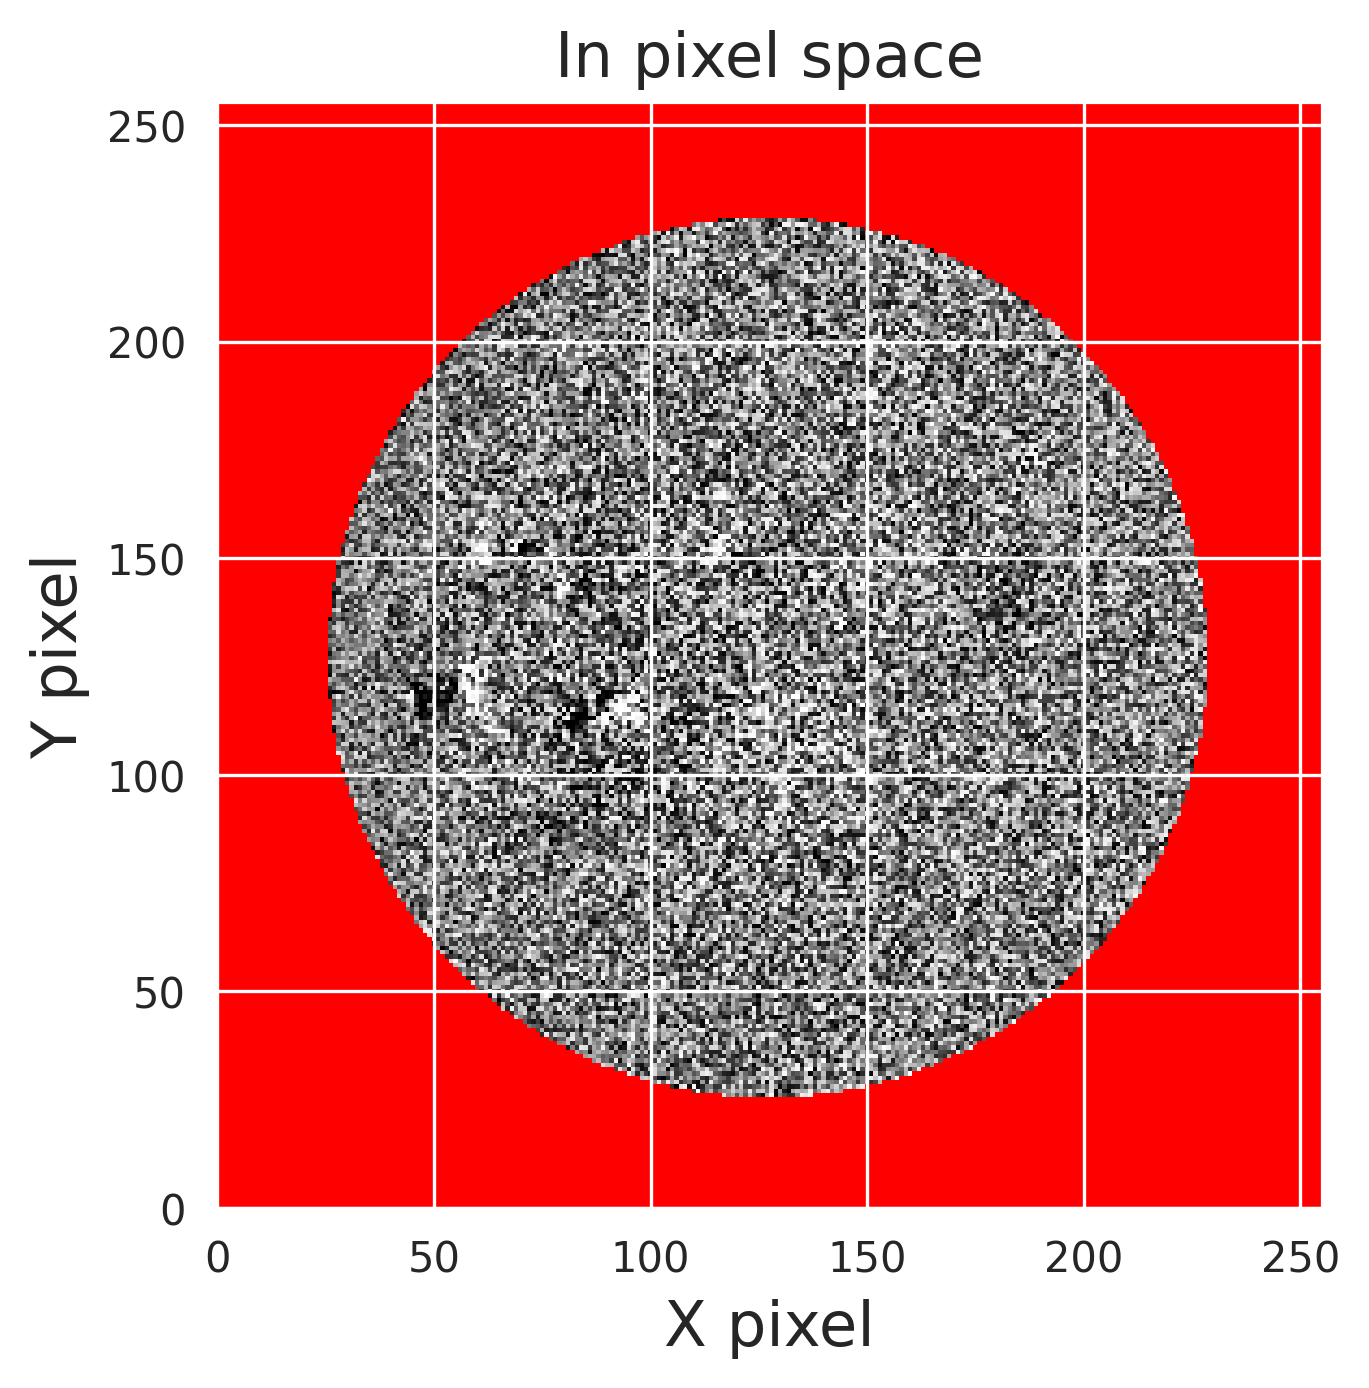
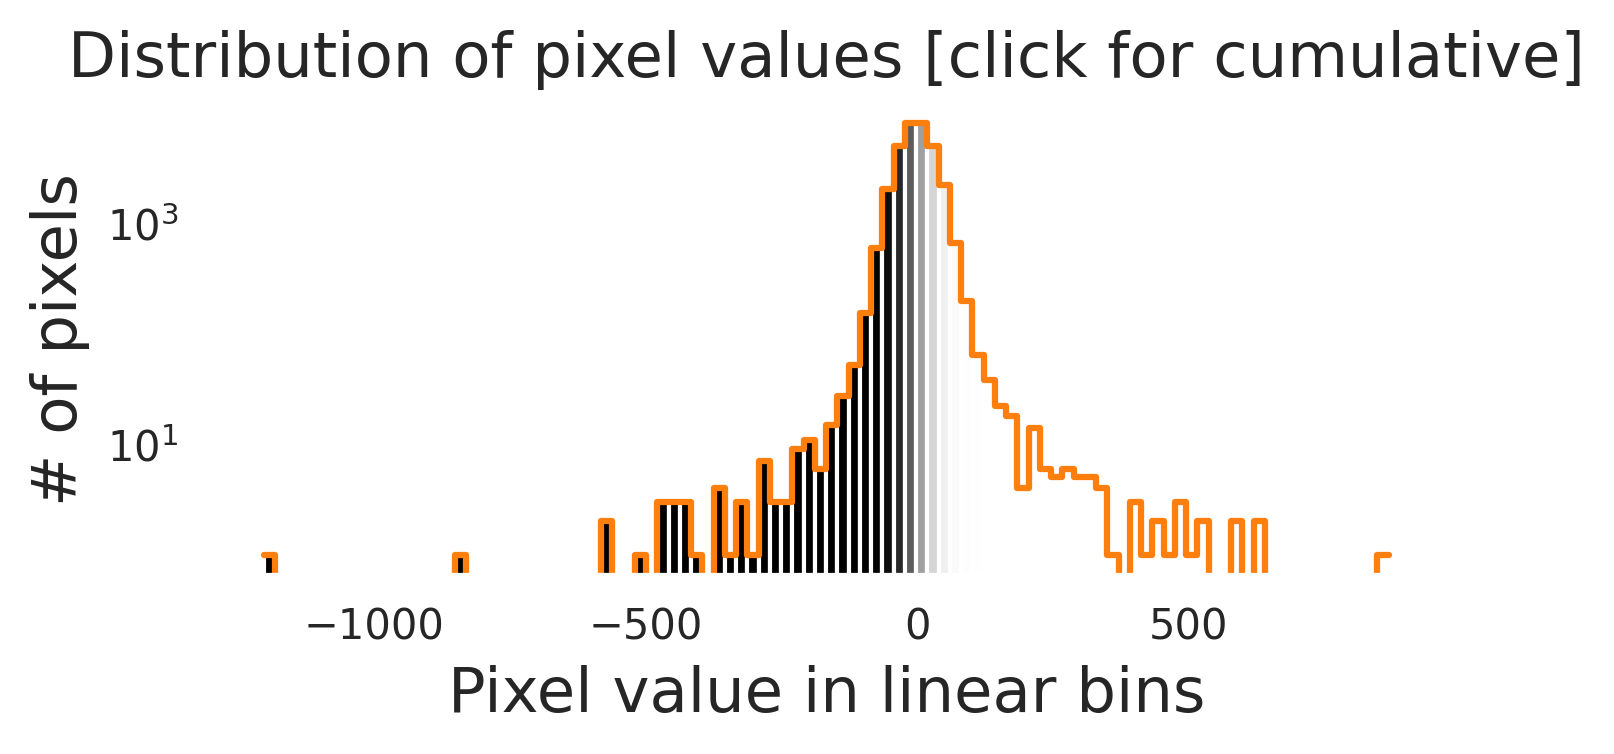
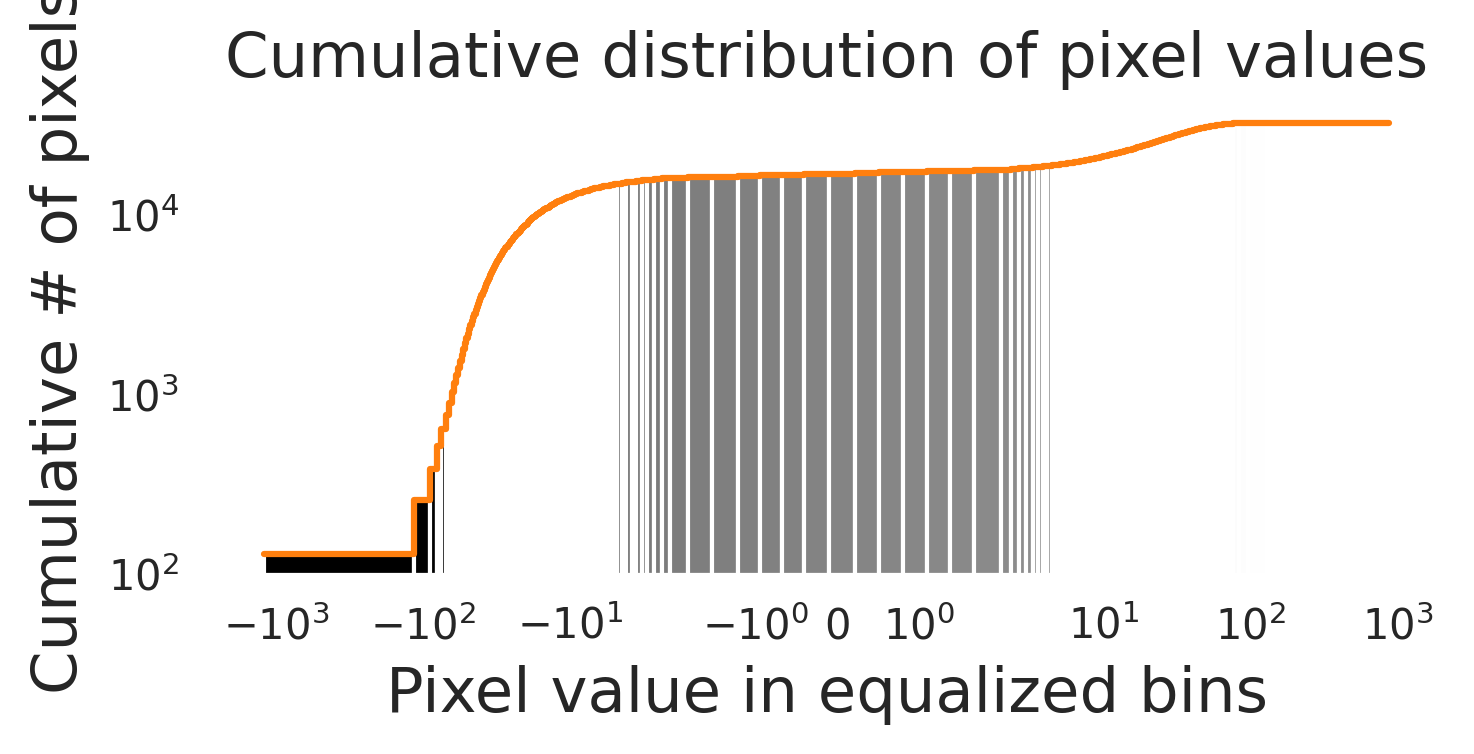

In [45]:
HMIm_2016[30]

In [46]:
HMIm_2016_matrix = np.array(list(d.data for d in HMIm_2016))
HMIm_2016_matrix.shape

(2908, 256, 256)

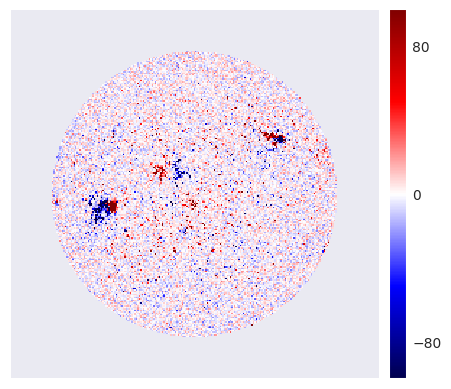

In [47]:
aia211_colormap = cm.color_tables.aia_color_table(211*u.angstrom)
isns.imshow(HMIm_2016_matrix[1100], cmap="seismic", vmin=-100, vmax=100)
plt.show()

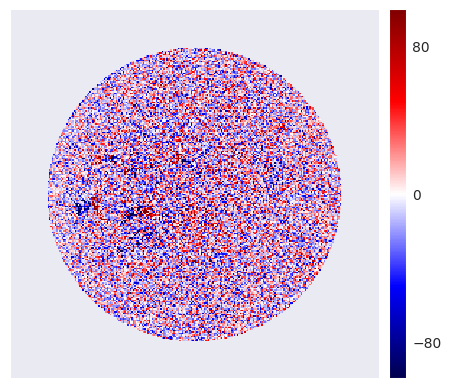

In [48]:
isns.imshow(HMIm_2016_matrix[30], cmap="seismic", vmin=-100, vmax=100)
plt.show()

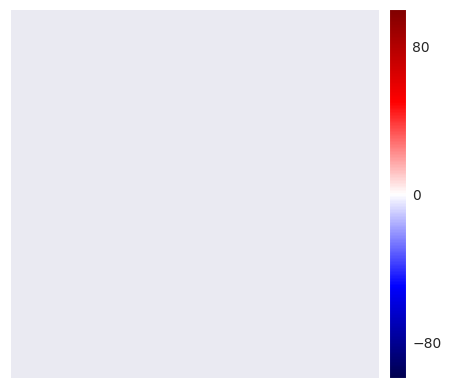

In [84]:
isns.imshow(HMIm_2016_matrix[188], cmap="seismic", vmin=-100, vmax=100)
plt.show()

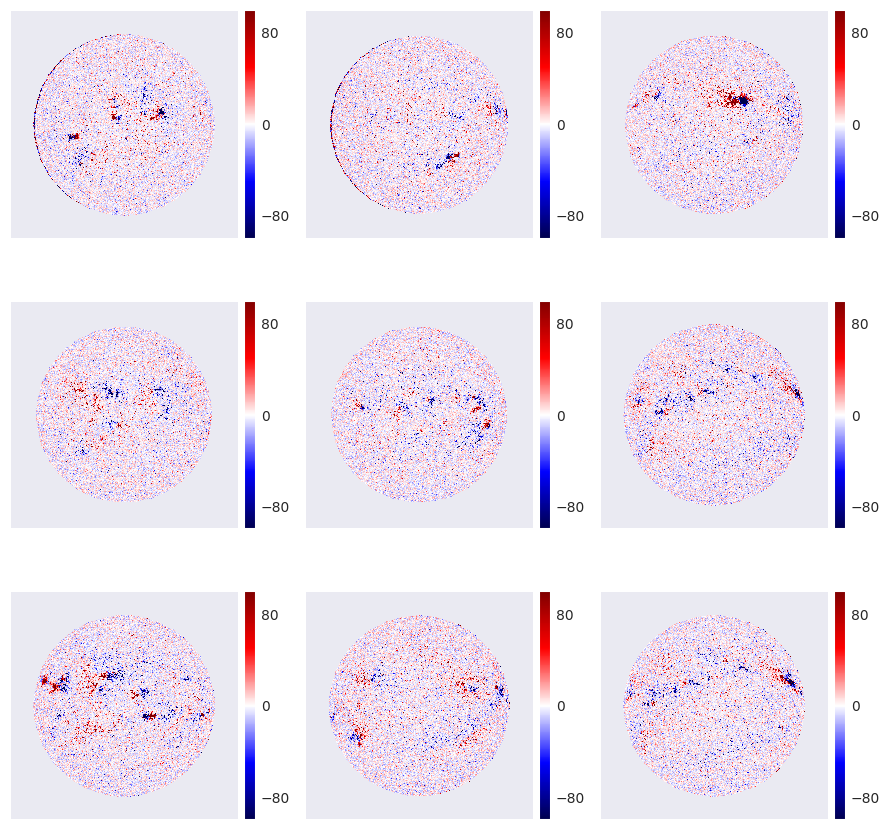

In [49]:
isns.ImageGrid(random.sample(list(HMIm_2016_matrix), 9), cmap="seismic", vmin=-100, vmax=100)

## Normalization

In [50]:
print(utils.range_tuple(HMIm_2016_matrix))
print(utils.range_tuple(HMIm_2016_matrix[188]))

(-4907.892314891231, 4930.260969088896)
(nan, nan)


/home/eugeniolr/Documents/master/TFM/utils.py:42: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(matrix), np.nanmax(matrix)


In [51]:
# min_values = AIA211_2016_matrix.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
# print(min_values.shape)

HMIm_clipped = np.clip(HMIm_2016_matrix, -100, 100)

max_values = np.nanmax(np.nanmax(np.abs(HMIm_clipped), axis=2, keepdims=True), axis=1, keepdims=True)
print(max_values.shape)
print(np.count_nonzero(max_values[max_values != 800]))

(2908, 1, 1)
2908


/tmp/ipykernel_16831/4125775763.py:6: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(HMIm_clipped), axis=2, keepdims=True), axis=1, keepdims=True)


In [52]:
HMIm_2016_mnorm = HMIm_clipped / max_values
utils.range_tuple(HMIm_2016_mnorm)

(-1.0, 1.0)

# Comparison between the histogram of a good image and a noisy image

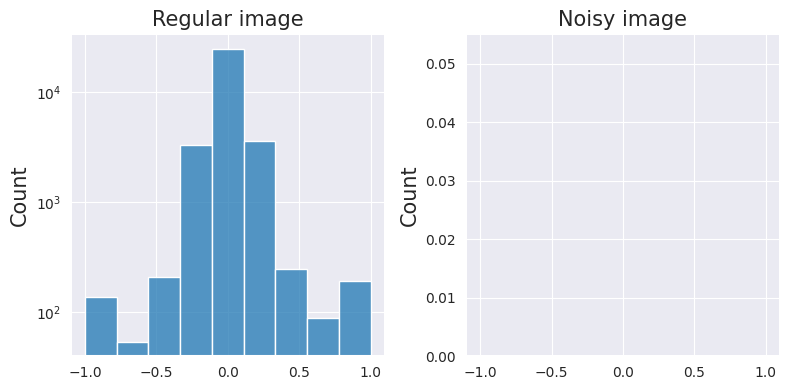

In [53]:
nbins = 10

fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 4]))

sns.histplot(HMIm_2016_mnorm[0].flatten(), bins=np.linspace(-1,1,nbins), ax=axes[0]).set(title="Regular image", yscale="log")

p = sns.histplot(HMIm_2016_mnorm[188].flatten(), bins=np.linspace(-1,1,nbins), ax=axes[1]).set(title="Noisy image", ylim=0)

fig.tight_layout()

## Noise detection model with kmeans

In [54]:
hist_vectors = np.array([np.histogram(i.flatten(), bins=np.linspace(-1,1,nbins))[0] for i in HMIm_2016_mnorm])

In [57]:
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(hist_vectors)

KMeans(n_clusters=4)

### Visualization of each class

In [62]:
class1 = HMIm_2016_mnorm[kmeans.labels_ == 0, :, :]  # since we know the first image is not noise
class2 = HMIm_2016_mnorm[kmeans.labels_ == 1, :, :]
class3 = HMIm_2016_mnorm[kmeans.labels_ == 2, :, :]
class4 = HMIm_2016_mnorm[kmeans.labels_ == 3, :, :]
print(class1.shape)
print(class2.shape)
print(class3.shape)
print(class4.shape)

(1335, 256, 256)
(20, 256, 256)
(1533, 256, 256)
(20, 256, 256)


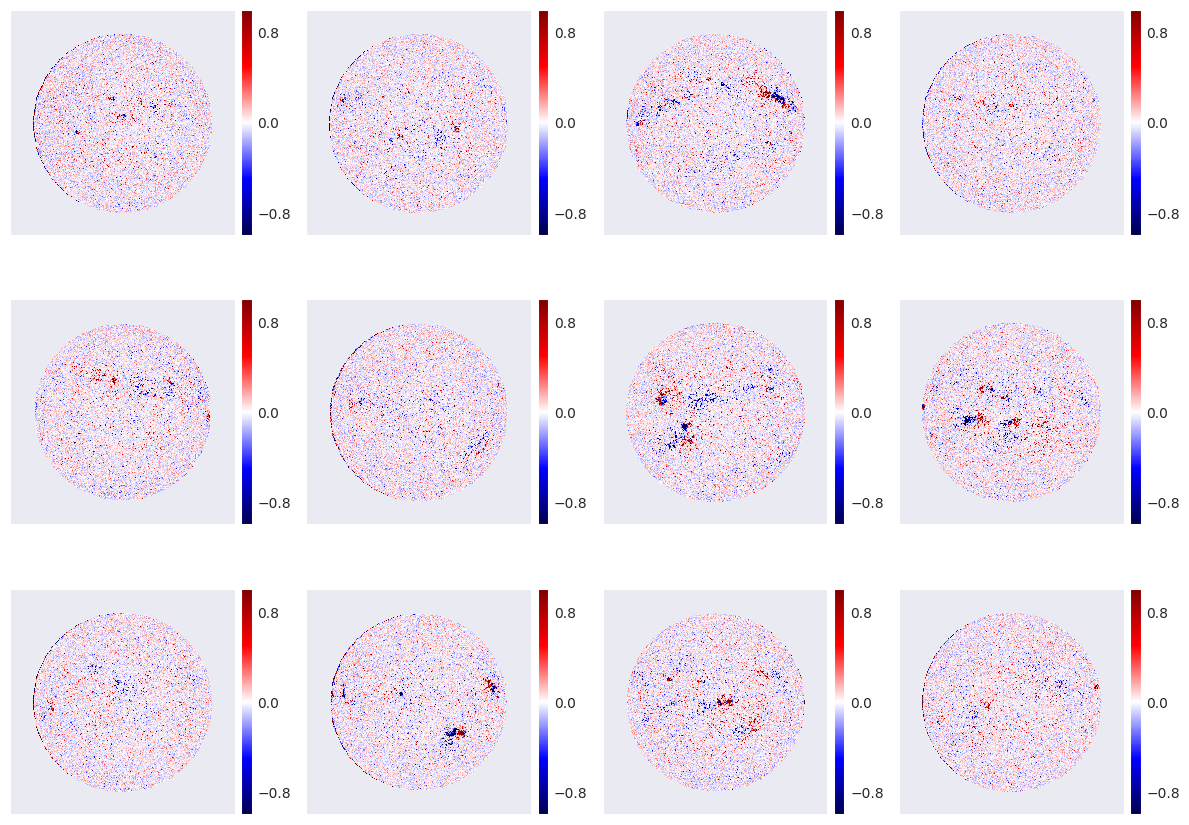

In [83]:
isns.ImageGrid(random.sample(list(class1), 12), cmap="seismic", col_wrap=4, vmin=-1, vmax=1)
plt.show()

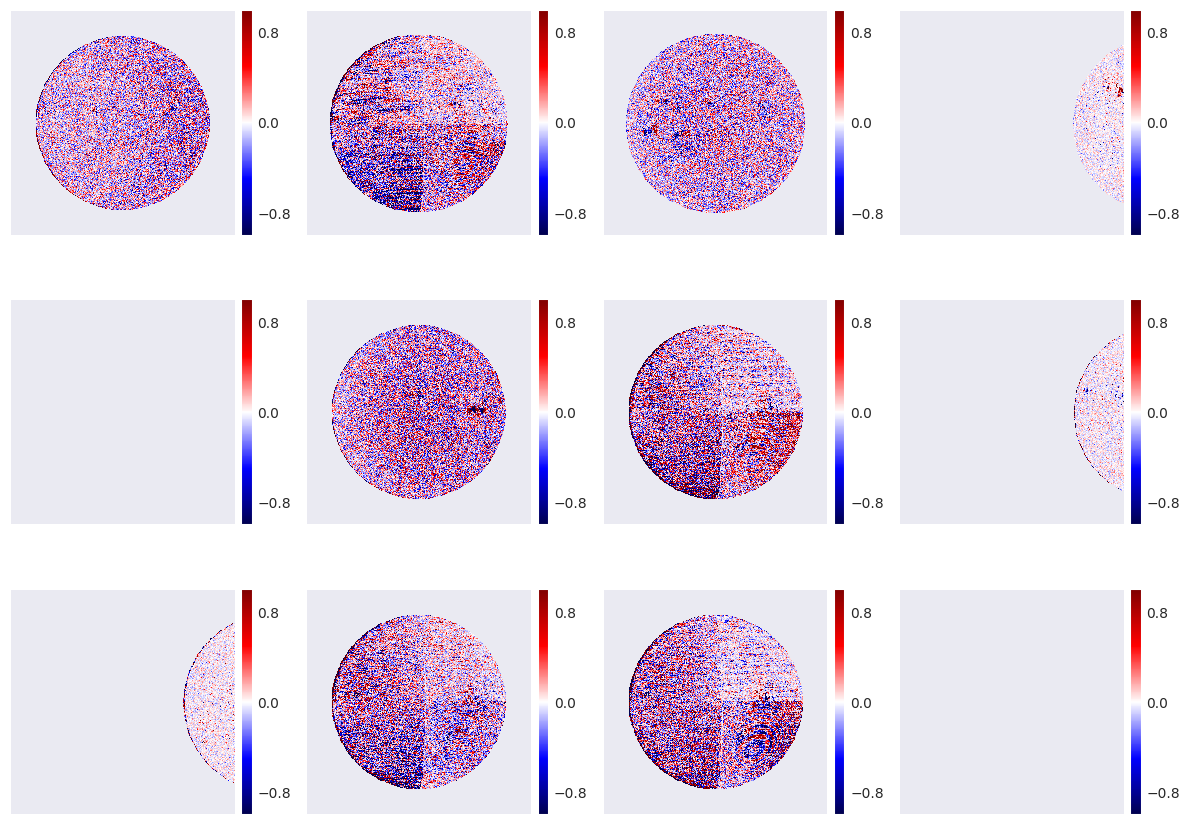

In [78]:
isns.ImageGrid(random.sample(list(class2), 12), cmap="seismic", col_wrap=4, vmin=-1, vmax=1)
plt.show()

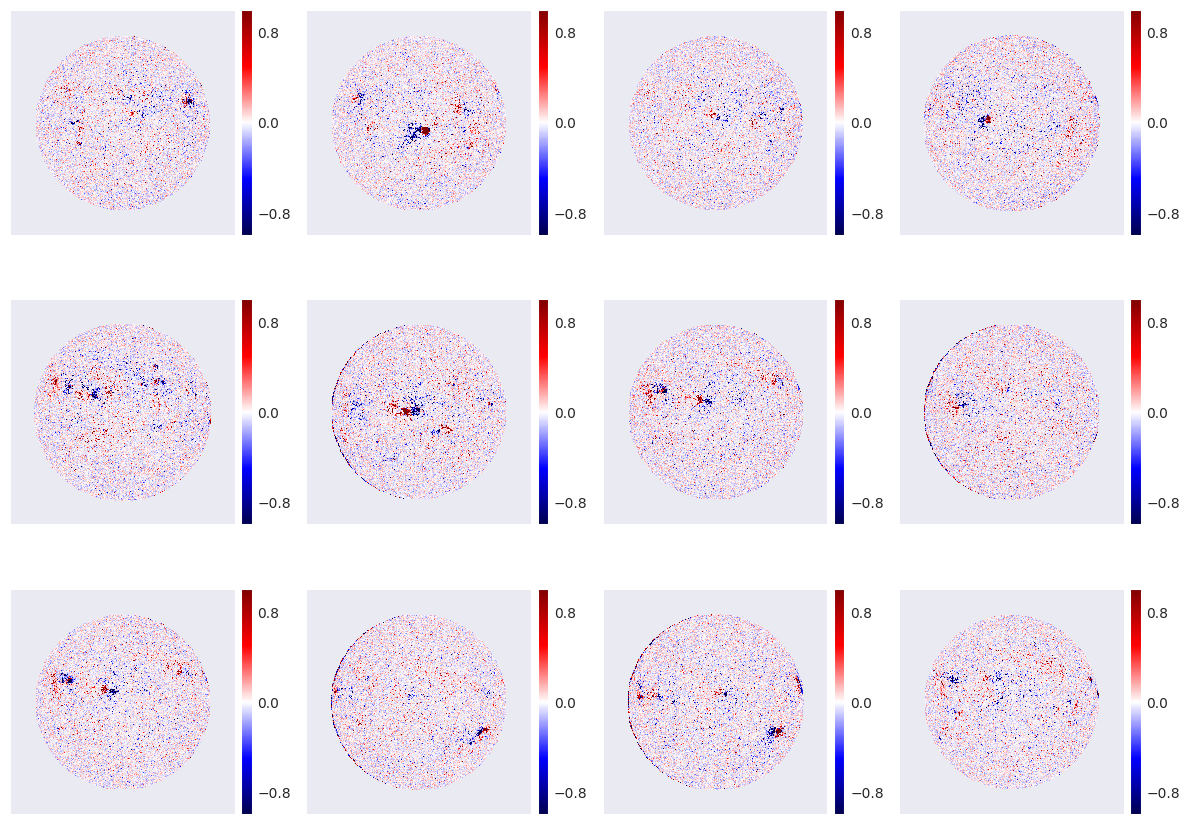

In [76]:
isns.ImageGrid(random.sample(list(class3), 12), cmap="seismic", col_wrap=4, vmin=-1, vmax=1)
plt.show()

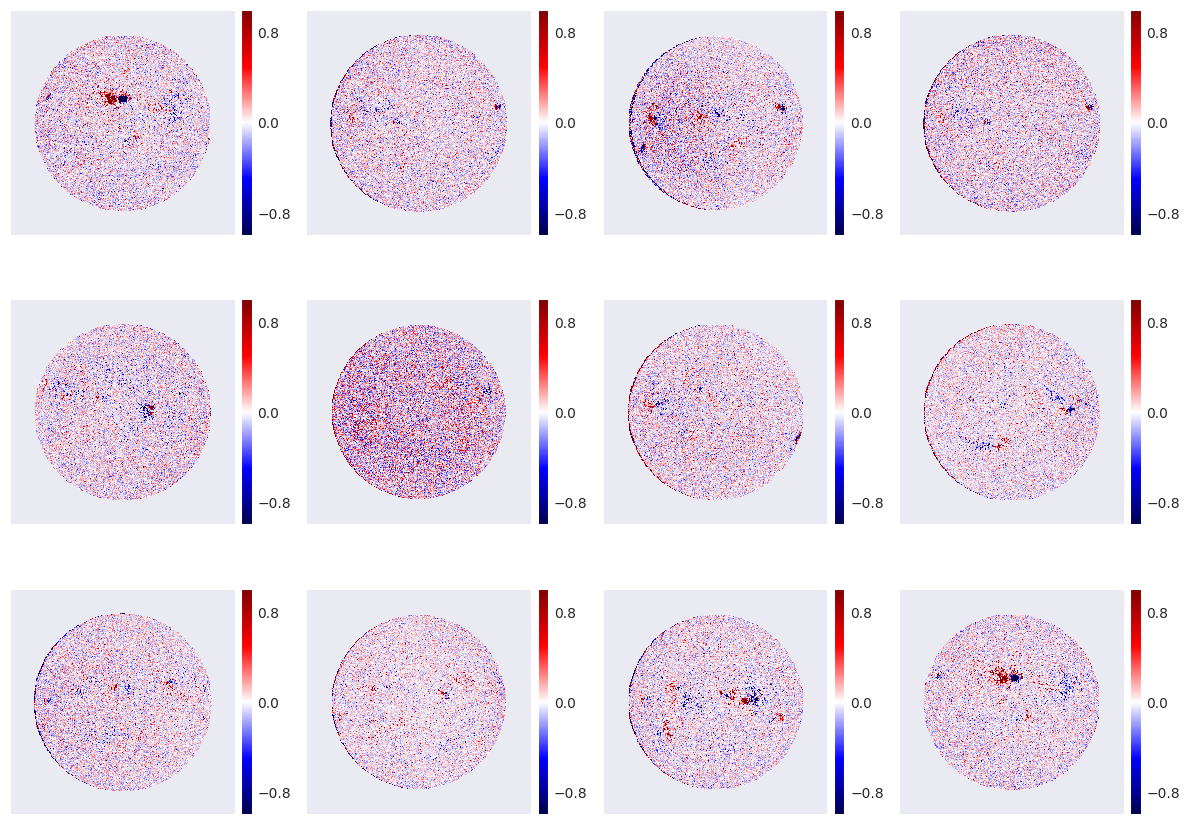

In [73]:
isns.ImageGrid(random.sample(list(class4), 12), cmap="seismic", col_wrap=4, vmin=-1, vmax=1)
plt.show()

## We use the model to identify noisy images in the datase

In [85]:
file_list = []
kmeans_list = []

year_list = set(map(lambda x: x[:4], os.listdir("data/hmi_magnetogram")))

for year in year_list: 
    img_file_list = glob.glob(f"data/hmi_magnetogram/{year}*.fits")
    img_list = sunpy.map.Map(img_file_list)
    img_matrix = np.array(list(map(lambda x: x.data, img_list)))

    max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)

    img_norm = img_matrix / max_values
    img_flat_array = img_norm.reshape([img_norm.shape[0], img_norm.shape[1]*img_norm.shape[2]])
    for j, img_flat in enumerate(img_flat_array):
        hist_array, _ = np.histogram(img_flat, bins=np.linspace(-1,1,nbins))
        k = kmeans.predict(hist_array.reshape([1, -1]))[0]
        kmeans_list.append(k)
        if k == kmeans.labels_[188]:
            print(img_file_list[j])
            file_list.append(img_file_list[j])


/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2013-04-14T15-01-30.fits
data/hmi_magnetogram/2013-10-13T12-01-30.fits
data/hmi_magnetogram/2013-10-13T09-01-30.fits
data/hmi_magnetogram/2013-04-14T09-01-30.fits
data/hmi_magnetogram/2013-04-14T12-01-30.fits
data/hmi_magnetogram/2013-10-13T15-01-30.fits


/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2019-09-04T00-01-30.fits
data/hmi_magnetogram/2019-02-15T18-01-30.fits
data/hmi_magnetogram/2019-09-03T15-01-30.fits
data/hmi_magnetogram/2019-09-03T18-01-30.fits
data/hmi_magnetogram/2019-07-28T06-01-30.fits
data/hmi_magnetogram/2019-02-15T21-01-30.fits
data/hmi_magnetogram/2019-02-16T00-01-30.fits
data/hmi_magnetogram/2019-09-03T21-01-30.fits


/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2020-01-19T18-01-30.fits
data/hmi_magnetogram/2020-01-19T12-01-30.fits
data/hmi_magnetogram/2020-01-19T09-01-30.fits
data/hmi_magnetogram/2020-01-19T15-01-30.fits


/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2018-10-07T09-01-30.fits
data/hmi_magnetogram/2018-01-21T18-01-30.fits
data/hmi_magnetogram/2018-01-21T09-01-30.fits
data/hmi_magnetogram/2018-01-21T12-01-30.fits
data/hmi_magnetogram/2018-01-21T15-01-30.fits


/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2014-01-19T15-01-30.fits
data/hmi_magnetogram/2014-11-16T06-01-30.fits
data/hmi_magnetogram/2014-07-27T12-01-30.fits
data/hmi_magnetogram/2014-04-06T15-01-30.fits
data/hmi_magnetogram/2014-01-19T12-01-30.fits
data/hmi_magnetogram/2014-07-27T15-01-30.fits
data/hmi_magnetogram/2014-11-16T12-01-30.fits
data/hmi_magnetogram/2014-11-16T09-01-30.fits
data/hmi_magnetogram/2014-07-27T09-01-30.fits
data/hmi_magnetogram/2014-04-06T12-01-30.fits
data/hmi_magnetogram/2014-01-19T18-01-30.fits
data/hmi_magnetogram/2014-11-16T15-01-30.fits
data/hmi_magnetogram/2014-04-06T09-01-30.fits
data/hmi_magnetogram/2014-01-19T09-01-30.fits


/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2012-10-17T12-01-30.fits
data/hmi_magnetogram/2012-10-22T21-01-30.fits
data/hmi_magnetogram/2012-10-24T18-01-30.fits
data/hmi_magnetogram/2012-10-22T18-01-30.fits
data/hmi_magnetogram/2012-10-24T12-01-30.fits
data/hmi_magnetogram/2012-12-06T15-01-30.fits
data/hmi_magnetogram/2012-10-17T16-03-00.fits
data/hmi_magnetogram/2012-10-16T15-01-30.fits
data/hmi_magnetogram/2012-12-06T21-01-30.fits
data/hmi_magnetogram/2012-10-19T18-01-30.fits
data/hmi_magnetogram/2012-10-18T21-01-30.fits
data/hmi_magnetogram/2012-10-14T15-01-30.fits
data/hmi_magnetogram/2012-10-22T15-01-30.fits
data/hmi_magnetogram/2012-10-25T18-01-30.fits
data/hmi_magnetogram/2012-10-23T12-01-30.fits
data/hmi_magnetogram/2012-10-14T09-01-30.fits
data/hmi_magnetogram/2012-10-19T12-01-30.fits
data/hmi_magnetogram/2012-12-07T15-01-30.fits
data/hmi_magnetogram/2012-12-07T18-01-30.fits
data/hmi_magnetogram/2012-10-26T18-01-30.fits
data/hmi_magnetogram/2012-12-10T15-01-30.fits
data/hmi_magnetogram/2012-10-26T15

/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2015-04-12T09-01-30.fits
data/hmi_magnetogram/2015-10-11T12-01-30.fits
data/hmi_magnetogram/2015-10-11T09-01-30.fits
data/hmi_magnetogram/2015-02-01T12-01-30.fits
data/hmi_magnetogram/2015-10-11T15-01-30.fits
data/hmi_magnetogram/2015-12-28T03-17-15.fits
data/hmi_magnetogram/2015-04-12T15-01-30.fits
data/hmi_magnetogram/2015-02-01T18-01-30.fits
data/hmi_magnetogram/2015-04-12T12-01-30.fits
data/hmi_magnetogram/2015-02-01T15-01-30.fits


/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2017-01-22T09-01-30.fits
data/hmi_magnetogram/2017-01-22T12-01-30.fits
data/hmi_magnetogram/2017-01-22T15-01-30.fits


/tmp/ipykernel_16831/3653301889.py:11: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(np.abs(img_matrix), axis=2, keepdims=True), axis=1, keepdims=True)


data/hmi_magnetogram/2016-05-01T15-01-30.fits
data/hmi_magnetogram/2016-05-01T09-01-30.fits
data/hmi_magnetogram/2016-05-01T12-01-30.fits
data/hmi_magnetogram/2016-10-23T12-01-30.fits
data/hmi_magnetogram/2016-10-23T15-01-30.fits
data/hmi_magnetogram/2016-07-24T09-01-30.fits
data/hmi_magnetogram/2016-01-24T18-01-30.fits
data/hmi_magnetogram/2016-07-24T15-01-30.fits
data/hmi_magnetogram/2016-07-24T12-01-30.fits
data/hmi_magnetogram/2016-01-24T12-01-30.fits
data/hmi_magnetogram/2016-10-23T09-01-30.fits
data/hmi_magnetogram/2016-01-24T15-01-30.fits


### A sample of noisy images

(12, 256, 256)


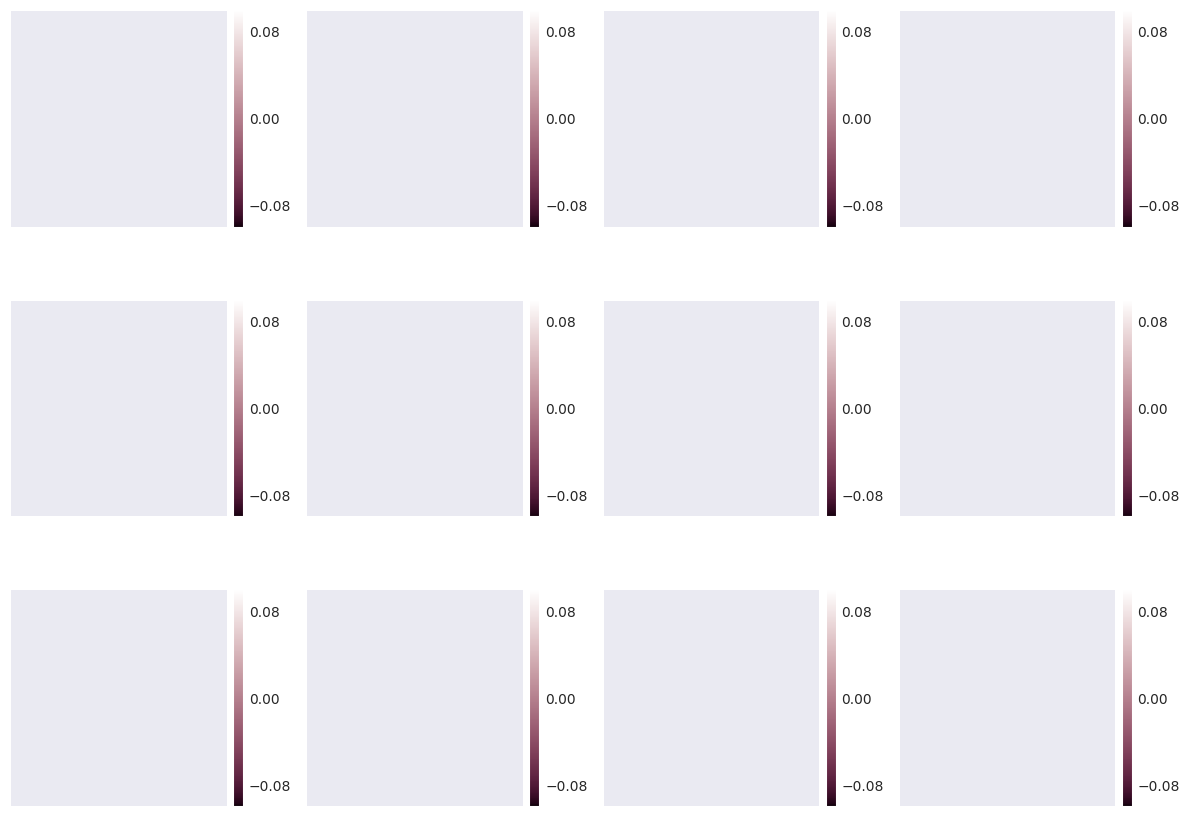

In [98]:
img_file_list = random.sample(file_list, k=12)
img_list = sunpy.map.Map(img_file_list)
img_matrix = np.array(list(map(lambda x: x.data, img_list)))

max_values = img_matrix.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

img_norm = img_matrix / max_values

isns.ImageGrid([i for i in img_norm], cmap=aia211_colormap, col_wrap=4)
plt.show()

In [ ]:
with open("noisy_HMI_m.csv", "w") as nf:
    for i in file_list:
        nf.write(i)
        nf.write("\n")